In [3]:
import pandas as pd
import numpy as np

EXPRESSION_FILE = 'sarl-spark/data/esets_breast_exprs_genes.txt'
SDRF_FILE = 'sarl-spark/data/E-MTAB-6703.sdrf.txt'

# --- Load Data ---
print("Loading gene expression data...")
try:
    gene_expression_df = pd.read_csv(EXPRESSION_FILE, sep='\t', index_col=0)
    print(f"Loaded expression data with shape: {gene_expression_df.shape}")
    print("First 5 rows of expression data:")
    print(gene_expression_df.head())
    print("\nFirst 5 columns of expression data:")
    print(gene_expression_df.iloc[:, :5].head())

except Exception as e:
    print(f"Error loading expression data: {e}")

print("\nLoading SDRF (Sample Data Relationship Format) file...")
try:
    sdrf_df = pd.read_csv(SDRF_FILE, sep='\t')
    print(f"Loaded SDRF data with shape: {sdrf_df.shape}")
    print("Relevant SDRF columns:")
    print(sdrf_df[['Source Name', 'Factor Value[disease]']].head())
except Exception as e:
    print(f"Error loading SDRF file: {e}")

Loading gene expression data...
Loaded expression data with shape: (20545, 2302)
First 5 rows of expression data:
        GSM85473.CEL  GSM85474.CEL  GSM85475.CEL  GSM85476.CEL  GSM85477.CEL  \
RFC2        7.085461      7.784006      8.698863      7.269989      7.231191   
HSPA6       6.584267      7.171879      9.252172      7.651452      8.790222   
PAX8        7.584432      7.634071      7.310996      7.279668      7.548172   
GUCA1A      5.633560      5.452583      5.782954      5.600526      5.543719   
THRA        6.547187      6.596162      6.751361      7.168780      5.949357   

        GSM85478.CEL  GSM85479.CEL  GSM85480.CEL  GSM85481.CEL  GSM85482.CEL  \
RFC2        7.757526      8.339538      6.217758      7.702109      6.057941   
HSPA6       7.486020      7.468479      8.248308      7.693082      6.093806   
PAX8        7.998011      7.895953      7.465762      7.299261      8.229284   
GUCA1A      5.679441      5.715836      5.964486      5.285099      6.338742   
THRA 

In [ ]:
# --- Transpose Expression Data ---
print("\nTransposing gene expression data...")
gene_expression_transposed = gene_expression_df.T
print(f"Transposed expression data shape: {gene_expression_transposed.shape}")
print("First 5 rows of transposed expression data:")
print(gene_expression_transposed.head())

# --- Clean up sample IDs in transposed data (remove '.CEL' suffix if present) ---
gene_expression_transposed.index = gene_expression_transposed.index.str.replace('.CEL', '', regex=False)
sdrf_df['Source Name Cleaned'] = sdrf_df['Source Name'].str.replace('.CEL', '', regex=False)

# --- Align Sample IDs and Merge Disease Information ---
disease_info = sdrf_df[['Source Name Cleaned', 'Factor Value[disease]']].set_index('Source Name Cleaned')

# Ensure unique index in disease_info before merging to avoid unexpected behavior
# This is important if multiple entries in SDRF refer to the same raw CEL file, but should be rare for Source Name
disease_info = disease_info[~disease_info.index.duplicated(keep='first')]

# Merge disease information into the transposed expression data
# This will add a 'Factor Value[disease]' column to our gene expression dataframe
print("\nMerging disease information with expression data...")
full_data_df = gene_expression_transposed.merge(disease_info, left_index=True, right_index=True, how='inner')
print(f"Dataframe with disease info shape: {full_data_df.shape}")
print("First 5 rows of merged data:")
print(full_data_df.head())

# Check for missing values (NaN) in the expression data
print("\nChecking for missing values in expression data (before filtering):")
print(full_data_df.drop(columns=['Factor Value[disease]']).isnull().sum().sum())

initial_samples_count = full_data_df.shape[0]
initial_genes_count = full_data_df.shape[1] - 1

full_data_df.dropna(inplace=True)
print(f"After dropping rows/columns with NaNs, shape: {full_data_df.shape}")
print(f"Dropped {initial_samples_count - full_data_df.shape[0]} samples due to NaNs.")
print(f"Dropped {initial_genes_count - (full_data_df.shape[1] - 1)} genes due to NaNs.")


Transposing gene expression data...
Transposed expression data shape: (2302, 20545)
First 5 rows of transposed expression data:
                  RFC2     HSPA6      PAX8    GUCA1A      THRA    PTPN21  \
GSM85473.CEL  7.085461  6.584267  7.584432  5.633560  6.547187  5.202941   
GSM85474.CEL  7.784006  7.171879  7.634071  5.452583  6.596162  6.185807   
GSM85475.CEL  8.698863  9.252172  7.310996  5.782954  6.751361  6.341080   
GSM85476.CEL  7.269989  7.651452  7.279668  5.600526  7.168780  7.827897   
GSM85477.CEL  7.231191  8.790222  7.548172  5.543719  5.949357  5.715767   

                   CCL5    CYP2E1     EPHB3     ESRRA  ...      NAF1  \
GSM85473.CEL   7.803543  5.181751  8.836065  6.487106  ...  6.515203   
GSM85474.CEL   9.094221  5.059557  8.765331  8.008657  ...  6.166754   
GSM85475.CEL  11.059747  4.502676  7.856687  7.585227  ...  6.141767   
GSM85476.CEL   6.789616  4.390577  9.446325  7.232152  ...  6.725774   
GSM85477.CEL   8.763134  4.821284  7.639209  8.612176 


Applying data reduction using Z-score normalization per gene...
Using Z-score threshold h = 2.0
First 5 rows of Z-score transformed data:
              RFC2     HSPA6      PAX8    GUCA1A      THRA    PTPN21  \
GSM85473 -0.184184 -0.940783  0.386786 -0.397908 -0.029645 -1.549391   
GSM85474  0.998015 -0.281934  0.544034 -1.164876  0.059567 -0.396720   
GSM85475  2.546298  2.050553 -0.479414  0.235215  0.342277 -0.214620   
GSM85476  0.128107  0.255777 -0.578655 -0.537902  1.102641  1.529066   
GSM85477  0.062445  1.532601  0.271920 -0.778646 -1.118645 -0.947965   

              CCL5    CYP2E1     EPHB3     ESRRA  ...      NAF1    CCDC63  \
GSM85473 -0.232180 -0.266402  0.752201 -1.940164  ...  0.078616 -1.605181   
GSM85474  0.852339 -0.449602  0.651720  1.709781  ... -0.455700  0.467388   
GSM85475  2.503915 -1.284512 -0.639069  0.694042  ... -0.494016  0.461391   
GSM85476 -1.084154 -1.452577  1.619116 -0.152925  ...  0.401508 -1.371249   
GSM85477  0.574137 -0.806836 -0.948011  3.1

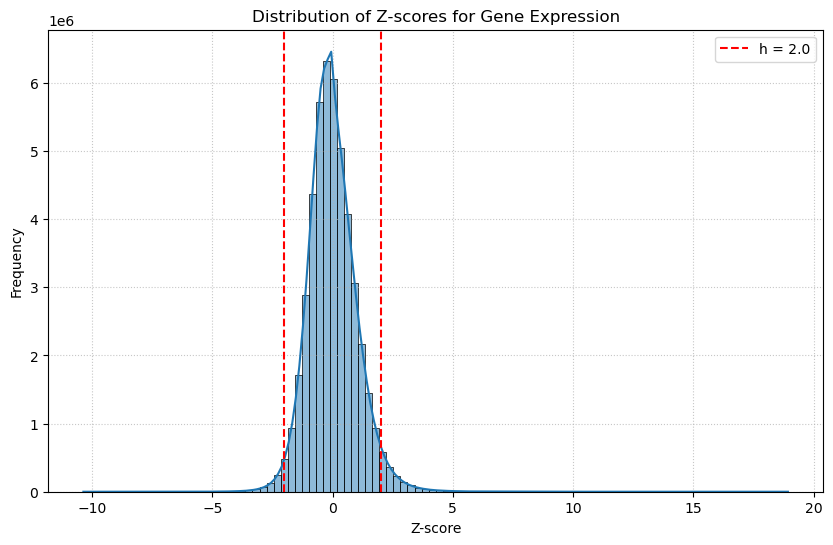

In [9]:
import pandas as pd
import numpy as np

# Assuming 'full_data_df' is already loaded and cleaned as in previous steps

print("\nApplying data reduction using Z-score normalization per gene...")

# 1. Separate gene expression data from disease status
gene_expression_only_df = full_data_df.drop(columns=['Factor Value[disease]'])

# 2. Calculate mean and standard deviation for EACH GENE across ALL SAMPLES
# axis=0 means operations are performed column-wise (per gene)
gene_means = gene_expression_only_df.mean(axis=0)
gene_stds = gene_expression_only_df.std(axis=0)

# Handle cases where std is 0 (gene has no variation, often very low expression or all same value)
# Replacing 0 with a small epsilon to avoid division by zero.
gene_stds[gene_stds == 0] = np.finfo(float).eps # np.finfo(float).eps is smallest representable float

# 3. Calculate Z-scores for each gene in each sample
# Subtract the mean and divide by the standard deviation for each gene's column
z_scores_df = (gene_expression_only_df - gene_means) / gene_stds

# --- Define the Z-score threshold h ---
# Common Z-score thresholds are 1.96 (for 95% confidence interval), 2.0, or 3.0
z_score_h = 2.0 # Genes with Z-score > 2.0 or < -2.0 will be considered significant

print(f"Using Z-score threshold h = {z_score_h}")
print("First 5 rows of Z-score transformed data:")
print(z_scores_df.head())

# 4. Convert to transactional data based on Z-scores
transactional_data_zscore = []

for sample_id, row_data in z_scores_df.iterrows():
    transaction = []
    # Retrieve the original disease status for the current sample
    disease_status = full_data_df.loc[sample_id, 'Factor Value[disease]']

    for gene_name, z_score in row_data.items():
        if z_score > z_score_h:
            transaction.append(f"+{gene_name}")
        elif z_score < -z_score_h:
            transaction.append(f"-{gene_name}")
        # Else, the gene is considered "normal" and not added to the transaction

    transaction.append(str(disease_status))
    transactional_data_zscore.append(transaction)

print(f"Generated {len(transactional_data_zscore)} transactions using Z-scores.")
print("\nFirst 5 transactions after Z-score based reduction:")
for i, transaction in enumerate(transactional_data_zscore[:5]):
    print(f"Transaction {i+1}: {transaction}")

# Check distribution of Z-scores (optional, but good for understanding)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(z_scores_df.stack(), bins=100, kde=True)
plt.axvline(x=z_score_h, color='r', linestyle='--', label=f'h = {z_score_h}')
plt.axvline(x=-z_score_h, color='r', linestyle='--')
plt.title('Distribution of Z-scores for Gene Expression')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

In [ ]:
print("\nCalculating gene importance...")

# Exclude the disease column for gene expression calculations
gene_expression_only_df = full_data_df.drop(columns=['Factor Value[disease]'])

# Calculate the average expression level of all genes (across all samples and all genes)
# This is K_j_avg = (sum_j K_j) / m from your formula
overall_average_expression = gene_expression_only_df.values.mean()
print(f"Overall average gene expression (log2): {overall_average_expression:.4f}")

# Calculate the average expression level for each individual gene (across all samples)
# This is K_g_avg = (sum_i K_gi) / t from your formula
average_expression_per_gene = gene_expression_only_df.mean(axis=0)

# Calculate gene importance for each gene
# E_g = |overall_average_expression - average_expression_per_gene|
gene_importance = (overall_average_expression - average_expression_per_gene).abs()

# Sort genes by importance in descending order
gene_importance_sorted = gene_importance.sort_values(ascending=False)

print("\nTop 10 most important genes:")
print(gene_importance_sorted.head(10))

print("\nBottom 10 least important genes:")
print(gene_importance_sorted.tail(10))

# You can save this importance list for later use in ranking association rules
# gene_importance_sorted.to_csv('gene_importance.csv', header=True)
# print("\nGene importance saved to 'gene_importance.csv'")